<h1 style="font-size:3em; text-align: center">Multi-Step Forecasting With Keras LSTM Neural Network</h1>


In [5]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras        import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

# fixes the random number seed to ensure reproducible results
np.random.seed(69)

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

# Imports the Same Dataset as The Other Models

This model reads the same dataset as the Single Step model except that the time grouping is set back to the original 5 minutes. When compiled and trained with the previous 15 minute interval data, the model was less accurate. At a simple cost of computational time, we were able to see more accurately the potential of LSTM RNN's for our purposes of Time Series Forecasting.

In [6]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*17)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()
dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*7
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    # reshape the dataset
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    # un-normalize the data set
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predictAt(point):
    pred = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back))
    actu = dataset_orig[point:point+look_forward]
    plt.plot(pred.reshape(look_forward))
    plt.plot(actu)
    plt.show()

def predict (day=14, total_days=1, delta=1, show_gradual_error=True):
    predictions, true_vals = np.array([]), np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction, color="red", alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals = np.append(true_vals,dataset_orig[i:i+look_forward]) 
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    print "%.2f RMSE" % (math.sqrt(mean_squared_error(true_vals, predictions)))
    plt.plot(range(288*day,288*day+288*total_days),dataset_orig[288*day:288*day+288*total_days,0])
    plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = abs(true_vals[:,i]) - abs(predictions[:,i])
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.show()

def over_penalty(y_true, y_pred):
    true_error = y_true-y_pred
    return K.sqrt(K.square(true_error) * K.square(K.sign(true_error) - 0.4))


# LSTM Model with RMS Propogation
When doing research on designing a custom loss function, I found an optimizer that was said to be better suited for recurrent neural networks (Such as our model). I copied the code for the optimizer and halved the learning rate and set the learning decay to 0.0002

Epoch 1/5
1s - loss: 0.0099
Epoch 2/5
1s - loss: 0.0037
Epoch 3/5
1s - loss: 0.0033
Epoch 4/5
1s - loss: 0.0032
Epoch 5/5
1s - loss: 0.0028
Epoch 1/2
3s - loss: 0.0052
Epoch 2/2
3s - loss: 0.0036
184.71 RMSE


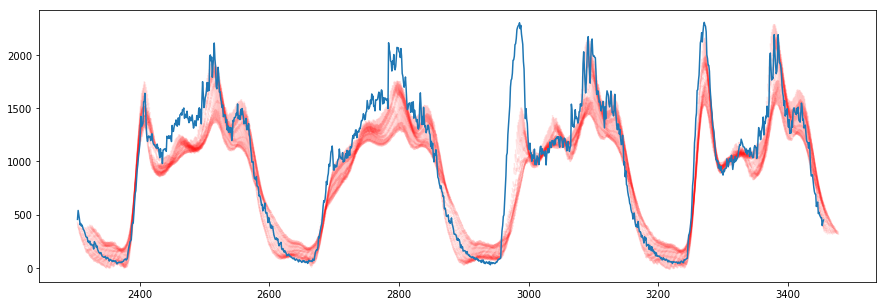

In [8]:
np.random.seed(1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(look_forward, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))

model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=3, verbose=2)
batch = 1
for i in range (batch):
    model.fit(trainX, trainY, epochs=2, batch_size=batch, verbose=2)
predict(day=8, total_days=4, show_gradual_error=False)
K.clear_session()

# LSTM Model with RMS Prop and Custom Loss

This custom loss function penalizes any overestimates of the model, so that the model avoids overestimating the true value. In the real world, it is more resource efficient for the company to allocate fewer autonomous vehicles to a certain location and send more if necessary than to send more than was necessary.

Epoch 1/5
8s - loss: 0.0097
Epoch 2/5
7s - loss: 0.0037
Epoch 3/5
7s - loss: 0.0033
Epoch 4/5
6s - loss: 0.0032
Epoch 5/5
7s - loss: 0.0028
Epoch 1/1
20s - loss: 0.0054
211.13 RMSE


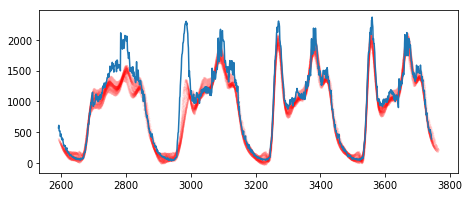

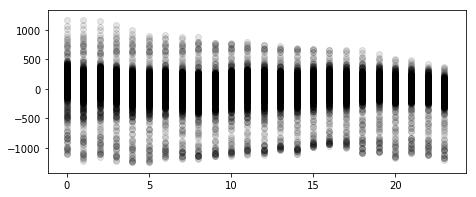

In [12]:
np.random.seed(1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(look_forward, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))

model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=3, verbose=2)
batch = 3
for i in range (batch):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)
predict()

## Manipulates the Dataset and Splits the Dataset

## create_dataset()

This function, given a dataset and optionally a look_back variable will generate two matrices. The first will be a matrix with all of the inputs for multiple training sets. The second will be a matrix with the output(s) that the LSTM should have.

<table>
    <tr>
        <th style='text-align: left'>Variables</th>
        <th style='text-align: left'>Description</th>
    </tr>
    <tr>
        <td style='text-align:left'><b>dataset</b></td> 
        <td style='text-align:left'>The dataset which will be split into two input and output matrices</td>
    </tr>
    <tr>
        <td style='text-align:left'><b>look_back</b></td>
        <td style='text-align:left'>(Def = 1) This variable determines how many inputs will be in each row of the input matrix. </td>
    </tr>
</table>

## Uses the Above Function to Create the Training and Test Sets and Reshapes them

### trainX and testX

A matrix where each row is an array of the input(s) depending on look_back

### trainY and testY

A matrix where each row is an array of the desired output(s)

## Generates and Trains an LSTM Neural Network with Keras

The model consists of a chain of 4 LSTM Neurons and a Dense layer with an output of 1. The input shape is an matrix with one row and as many features as the look_back variable describes. In other words, this model takes the some number of inputs (depending on look_back) and will return a single output.

The model is then fit using the training set, with a batch_size of 3 and 5 epochs. This fitting process can be done but runs the risk of over-fitting the LSTM Network.

Epoch 1/5
2s - loss: 0.0131
Epoch 2/5
0s - loss: 0.0066
Epoch 3/5
0s - loss: 0.0056
Epoch 4/5
0s - loss: 0.0049
Epoch 5/5
0s - loss: 0.0044


In [755]:
batch = 3
for i in range (30):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
0s - loss: 0.0032
Epoch 1/1
0s - loss: 0.0030
Epoch 1/1
0s - loss: 0.0030
Epoch 1/1
0s - loss: 0.0028
Epoch 1/1
0s - loss: 0.0028
Epoch 1/1
0s - loss: 0.0026
Epoch 1/1
1s - loss: 0.0025
Epoch 1/1
1s - loss: 0.0026
Epoch 1/1
0s - loss: 0.0025
Epoch 1/1
0s - loss: 0.0024
Epoch 1/1
0s - loss: 0.0023
Epoch 1/1
0s - loss: 0.0023
Epoch 1/1
1s - loss: 0.0023
Epoch 1/1
1s - loss: 0.0023
Epoch 1/1
1s - loss: 0.0022
Epoch 1/1
0s - loss: 0.0022
Epoch 1/1
0s - loss: 0.0021
Epoch 1/1
0s - loss: 0.0021
Epoch 1/1
0s - loss: 0.0021
Epoch 1/1
0s - loss: 0.0021
Epoch 1/1
0s - loss: 0.0020
Epoch 1/1
1s - loss: 0.0020
Epoch 1/1
1s - loss: 0.0020
Epoch 1/1
1s - loss: 0.0020
Epoch 1/1
0s - loss: 0.0020
Epoch 1/1
0s - loss: 0.0019
Epoch 1/1
0s - loss: 0.0020


In [756]:
batch = 1
for i in range (20):
    if i % 5 == 0:
        print i
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

0
Epoch 1/1
2s - loss: 0.0024
Epoch 1/1
2s - loss: 0.0024
Epoch 1/1
2s - loss: 0.0024
Epoch 1/1
2s - loss: 0.0024
Epoch 1/1
2s - loss: 0.0023
5
Epoch 1/1
2s - loss: 0.0023
Epoch 1/1
2s - loss: 0.0023
Epoch 1/1
2s - loss: 0.0023
Epoch 1/1
2s - loss: 0.0023
Epoch 1/1
2s - loss: 0.0023
10
Epoch 1/1
2s - loss: 0.0022
Epoch 1/1
2s - loss: 0.0022
Epoch 1/1
2s - loss: 0.0023
Epoch 1/1
2s - loss: 0.0022
Epoch 1/1
2s - loss: 0.0022
15
Epoch 1/1
2s - loss: 0.0022
Epoch 1/1
2s - loss: 0.0021
Epoch 1/1
2s - loss: 0.0021
Epoch 1/1
2s - loss: 0.0021
Epoch 1/1
2s - loss: 0.0020


In [757]:
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    
    # reshape the dataset
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
    
    # make a prediction
    prediction = model.predict(data)
    
    # un-normalize the data set
    prediction = scaler.inverse_transform(prediction)
    
    return prediction

In [758]:
def predictAt(point):
    pred = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back))
    actu = dataset_orig[point:point+look_forward]
    plt.plot(pred.reshape(look_forward))
    plt.plot(actu)
    plt.show()

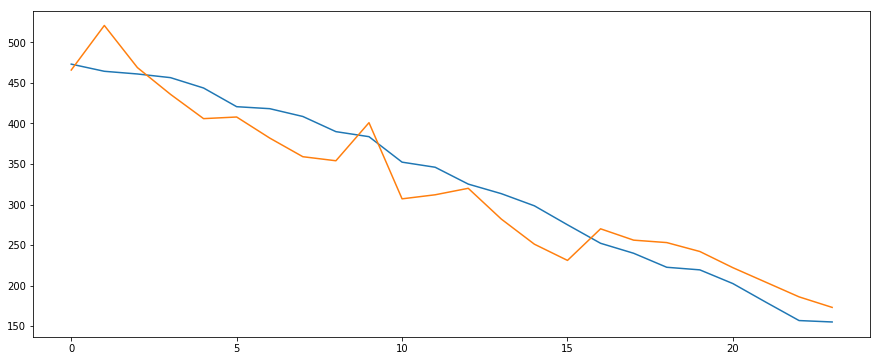

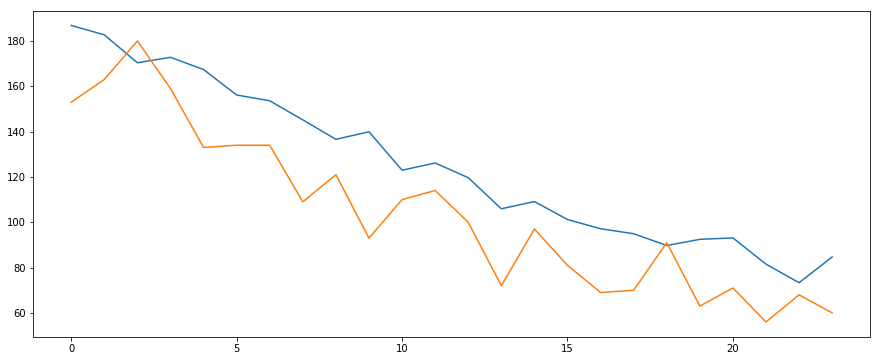

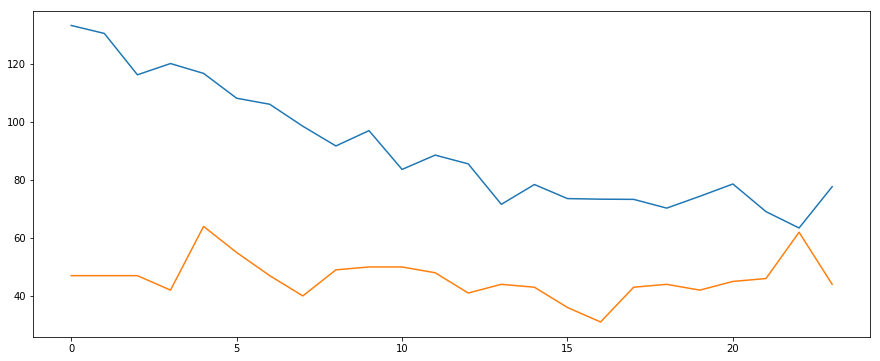

In [759]:
predictAt(288)
predictAt(288 + 24)
predictAt(288 + 48)

In [760]:
# day - the starting day 
# total_days - the number of days to graph
# delta - the interval between predictions (12 => 1H between pred, 1 => 5min between predictions)
def predict (day=8, total_days=1, delta=1, show_gradual_error=True):
    
    predictions = np.array([])
    true_vals = np.array([])

    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta

        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(24)

        # plots the predictions
        plt.plot(range(point, point+24),prediction, color="red", alpha=0.1)

        predictions = np.append(predictions, prediction)
        true_vals = np.append(true_vals,dataset_orig[i:i+24]) 

    predictions = predictions.reshape(len(predictions)/24, 24)
    true_vals = true_vals.reshape(len(true_vals)/24, 24)
    
    print "%.2f RMSE" % (math.sqrt(mean_squared_error(true_vals, predictions)))
    
    plt.plot(range(288*day,288*day+288*total_days),dataset_orig[288*day:288*day+288*total_days,0])
    plt.show()
    
    if show_gradual_error:
        err = np.array(range(24)).astype('float32')
        for i in range(look_forward):
            # calc RMSE
            err[i] = math.sqrt(mean_squared_error(true_vals[:,i],predictions[:,i]))
            # calc individial errors
            indiv_err = abs(true_vals[:,i] - predictions[:,i])
            indiv_err.sort()
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
            
        plt.plot(err)
        
        plt.show()

267.19 RMSE


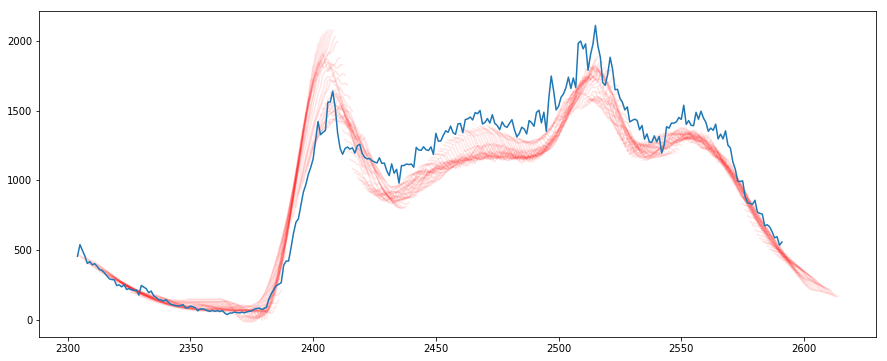

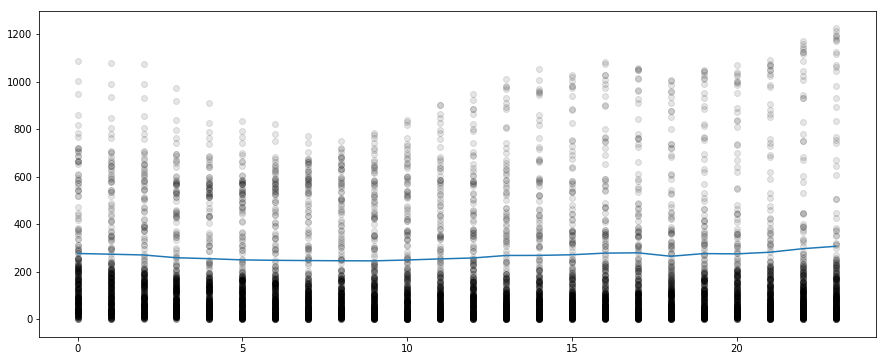

In [761]:
predict()

281.31 RMSE


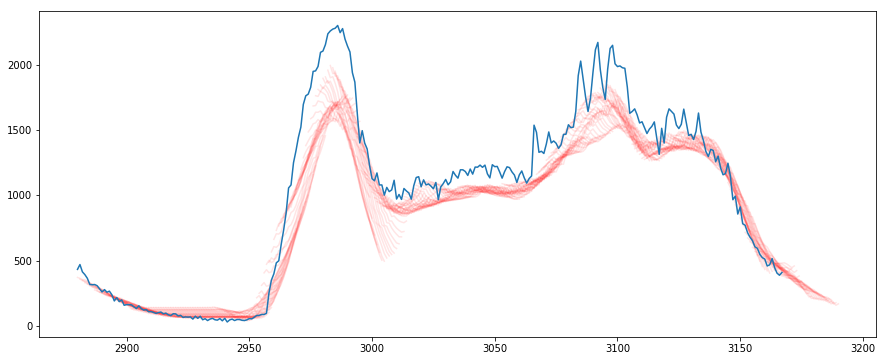

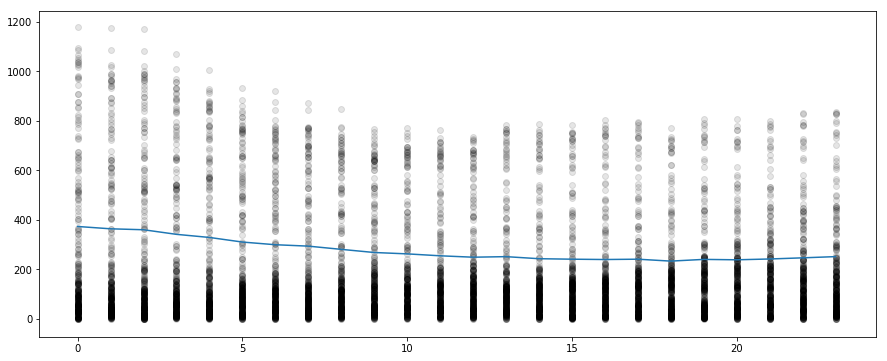

In [762]:
predict(day=10)

0